In [56]:
import pandas as pd

data = pd.read_csv('data_sample_three_years.csv')

data = data.iloc[:, [0,1,2,3,4]]
data.rename(columns={'date': 'open', 'low':'close', 'open':'high', 'high':'low'}, inplace=True)

data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.iloc[:, [0,5,1,2,3,4]]

data_backup = data.loc[ data.timestamp >= 1675814400 ]
data = data.loc[ data.timestamp < 1675814400 ]

from talib import RSI
data['rsi_14'] = RSI(data['close'], timeperiod=14)
data['rsi_14'] = data['rsi_14'].shift(1)

from talib import MA, SMA, EMA, WMA
data['ma_9'] = MA(data['close'], timeperiod=9)
data['ma_9'] = data['ma_9'].shift(1)
data['sma_9'] = SMA(data['close'], timeperiod=9)
data['sma_9'] = data['sma_9'].shift(1)
data['wma_9'] = WMA(data['close'], timeperiod=9)
data['wma_9'] = data['wma_9'].shift(1)

from talib import MACD
data['macd'], data['signal'], data['hist'] = MACD(data['close'])
data['macd'] = data['macd'].shift(1)
data['signal'] = data['signal'].shift(1)
data['hist'] = data['hist'].shift(1)

from talib import ADX
data['adx'] = ADX(data['high'], data['low'], data['close'])
data['adx'] = data['adx'].shift(1)

from talib import ATR
data['atr'] = ATR(high=data['high'], low=data['low'], close=data['close'], timeperiod=14)
data['atr'] = data['atr'].shift(1)

from talib import SAR
data['sar'] = SAR(high=data['high'], low=data['low'], acceleration=0.02, maximum=0.2)
data['sar'] = data['sar'].shift(1)

from talib import TEMA
data['tema'] = TEMA(data['close'], timeperiod=14)
data['tema'] = data['tema'].shift(1)

from talib import ROC
data['roc'] = ROC(data['close'], timeperiod=14)
data['roc'] = data['roc'].shift(1)

data.dropna(axis=0, inplace=True)

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[list(data.columns[5:])])

scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(data[['close']])

In [58]:
data_scaled.shape

(16222, 13)

In [59]:
# to be used for sageMaker
subset_column_indices = [list(data.columns).index(col) for col in list(data.columns[8:])]

In [61]:
seq_length = 10  # Number of time steps in each sequence
num_features = len(data.columns[5:])
X_features = data_scaled
y_target = target_scaled

In [62]:
y_target

array([[0.22753633],
       [0.22885318],
       [0.23132733],
       ...,
       [0.19288547],
       [0.19351857],
       [0.19281709]])

In [63]:
X_features.shape

(16222, 13)

In [64]:
import numpy as np

# Create input sequences and targets
def create_sequences(features, target, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i+seq_length])  # Input sequence
        y_seq.append(target[i+seq_length]) # Target value (next data point)
    return np.array(X_seq), np.array(y_seq)

In [65]:
X_seq, y_seq = create_sequences(X_features, y_target, seq_length)

In [66]:
# Reshape X_seq to fit LSTM model input shape
X_seq = X_seq.reshape(X_seq.shape[0], seq_length, num_features)

In [67]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Build LSTM model
model = Sequential([
    Dense(20, activation='relu'),
    LSTM(50, input_shape=(seq_length, num_features)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Adding early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with early stopping
model.fit(X_seq, y_seq, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
406/406 [==============================] - 13s 13ms/step - loss: 0.0052 - val_loss: 3.0870e-04
Epoch 2/100
406/406 [==============================] - 4s 9ms/step - loss: 2.1914e-04 - val_loss: 7.9895e-05
Epoch 3/100
406/406 [==============================] - 4s 9ms/step - loss: 1.6876e-04 - val_loss: 6.7598e-05
Epoch 4/100
406/406 [==============================] - 4s 10ms/step - loss: 1.5098e-04 - val_loss: 5.8214e-05
Epoch 5/100
406/406 [==============================] - 4s 9ms/step - loss: 1.4930e-04 - val_loss: 4.2607e-05
Epoch 6/100
406/406 [==============================] - 5s 13ms/step - loss: 1.4128e-04 - val_loss: 1.0181e-04
Epoch 7/100
406/406 [==============================] - 4s 11ms/step - loss: 1.3537e-04 - val_loss: 3.4191e-05
Epoch 8/100
406/406 [==============================] - 4s 10ms/step - loss: 1.3349e-04 - val_loss: 1.1569e-04
Epoch 9/100
406/406 [==============================] - 5s 12ms/step - loss: 1.3582e-04 - val_loss: 6.9303e-05
Epoch 10/100
406

In [68]:
from talib import RSI
data_backup['rsi_14'] = RSI(data_backup['close'], timeperiod=14)
data_backup['rsi_14'] = data_backup['rsi_14'].shift(1)

from talib import MA, SMA, EMA, WMA
data_backup['ma_9'] = MA(data_backup['close'], timeperiod=9)
data_backup['ma_9'] = data_backup['ma_9'].shift(1)
data_backup['sma_9'] = SMA(data_backup['close'], timeperiod=9)
data_backup['sma_9'] = data_backup['sma_9'].shift(1)
data_backup['wma_9'] = WMA(data_backup['close'], timeperiod=9)
data_backup['wma_9'] = data_backup['wma_9'].shift(1)

from talib import MACD
data_backup['macd'], data_backup['signal'], data_backup['hist'] = MACD(data_backup['close'])
data_backup['macd'] = data_backup['macd'].shift(1)
data_backup['signal'] = data_backup['signal'].shift(1)
data_backup['hist'] = data_backup['hist'].shift(1)

from talib import ADX
data_backup['adx'] = ADX(data_backup['high'], data_backup['low'], data_backup['close'])
data_backup['adx'] = data_backup['adx'].shift(1)

from talib import ATR
data_backup['atr'] = ATR(high=data_backup['high'], low=data_backup['low'], close=data_backup['close'], timeperiod=14)
data_backup['atr'] = data_backup['atr'].shift(1)

from talib import SAR
data_backup['sar'] = SAR(high=data_backup['high'], low=data_backup['low'], acceleration=0.02, maximum=0.2)
data_backup['sar'] = data_backup['sar'].shift(1)

from talib import TEMA
data_backup['tema'] = TEMA(data_backup['close'], timeperiod=14)
data_backup['tema'] = data_backup['tema'].shift(1)

from talib import ROC
data_backup['roc'] = ROC(data_backup['close'], timeperiod=14)
data_backup['roc'] = data_backup['roc'].shift(1)

data_backup.dropna(axis=0, inplace=True)

In [70]:
data_backup_scaled = scaler.transform(data_backup[list(data_backup.columns[5:])])
target_backup_scaled = scaler_target.transform(data_backup[['close']])
X_b, y_b = create_sequences(data_backup_scaled, target_backup_scaled, seq_length)
X_b = X_b.reshape(X_b.shape[0], seq_length, num_features)

In [71]:
y_pred = model.predict(X_b)

252/252 [==============================] - 2s 4ms/step


In [72]:
y_pred = scaler_target.inverse_transform(y_pred)

In [73]:
y_pred

array([[1528.7399],
       [1539.0817],
       [1537.3406],
       ...,
       [2409.483 ],
       [2405.6917],
       [2405.8567]], dtype=float32)

In [74]:
data_backup.reset_index(inplace=True)

In [75]:
data_backup

,index,timestamp,date,open,high,low,close,rsi_14,ma_9,sma_9,wma_9,macd,signal,hist,adx,atr,sar,tema,roc
0,16302,1675976400,2023-02-09 21:00:00,1576.88,1577.69,1522.00,1539.79,18.616831,1624.940000,1624.940000,1617.970000,-14.541731,-12.566991,-1.974740,49.052362,15.341949,1645.808911,1606.997399,-2.599183
1,16303,1675980000,2023-02-09 22:00:00,1539.79,1548.88,1525.82,1537.48,13.480259,1614.594444,1614.594444,1600.940000,-20.104242,-14.074441,-6.029801,51.159707,18.223952,1640.931576,1581.257151,-5.192934
2,16304,1675983600,2023-02-09 23:00:00,1537.44,1549.09,1536.24,1544.68,13.235394,1603.625556,1603.625556,1585.517111,-24.417500,-16.143053,-8.274447,53.116527,18.569384,1631.417050,1561.521082,-5.913886
3,16305,1675987200,2023-02-10 00:00:00,1544.67,1554.00,1541.31,1548.03,18.221628,1593.022222,1593.022222,1573.728000,-26.944212,-18.303285,-8.640927,54.912918,18.160857,1622.663686,1549.802645,-5.233193
4,16306,1675990800,2023-02-10 01:00:00,1548.04,1552.54,1543.30,1549.23,20.510578,1583.097778,1583.097778,1564.729556,-28.349537,-20.312535,-8.037002,56.082093,17.770081,1614.610591,1542.866750,-5.172530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,24354,1707336000,2024-02-07 20:00:00,2418.66,2445.00,2418.66,2438.64,74.945286,2386.678889,2386.678889,2397.230889,15.256239,10.906498,4.349741,36.032015,15.923627,2367.919822,2409.291424,2.286222
8053,24355,1707339600,2024-02-07 21:00:00,2438.64,2439.27,2424.86,2429.71,79.375495,2395.336667,2395.336667,2407.623111,18.134300,12.352058,5.782242,38.558357,16.667654,2373.619840,2422.696035,3.199269
8054,24356,1707343200,2024-02-07 22:00:00,2429.71,2431.16,2421.03,2424.75,73.149791,2401.751111,2401.751111,2414.497778,19.470168,13.775680,5.694488,40.904246,16.506393,2382.185459,2429.222870,2.863590
8055,24357,1707346800,2024-02-07 23:00:00,2424.76,2429.61,2421.81,2424.22,69.871719,2407.653333,2407.653333,2419.097556,19.899236,15.000391,4.898845,42.626298,16.050936,2389.723204,2431.908273,2.635355


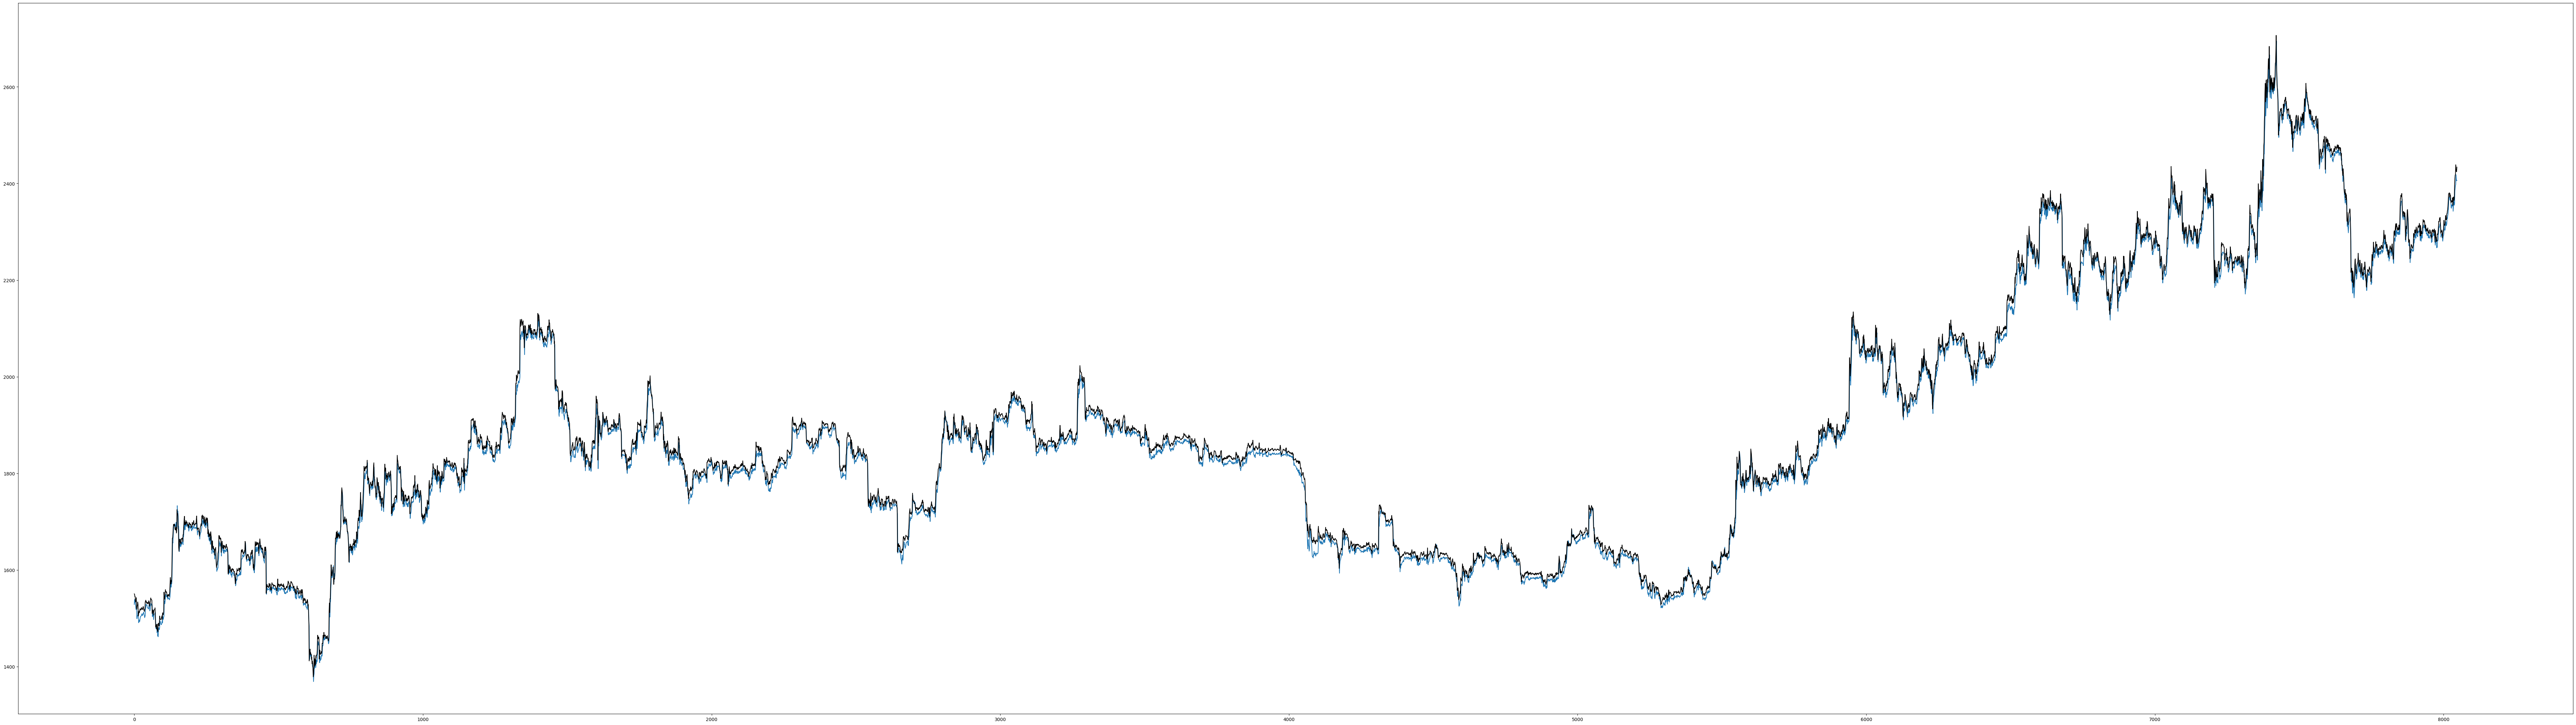

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

plt.plot(y_pred)
plt.plot(data_backup[['close']].shift(-10).values, color='black')
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error, accuracy_score

mean_squared_error(data_backup[['close']].iloc[10:], y_pred)

218.68012010395014

In [41]:
len(y_pred)

8047

In [42]:
y_pred_series = pd.Series(y_pred.reshape(1,-1)[0])

In [43]:
y_pred_series

0       1529.156128
1       1537.283325
2       1542.926636
3       1544.663818
4       1542.361328
           ...     
8042    2428.152344
8043    2425.126221
8044    2438.371582
8045    2420.665771
8046    2413.424561
Length: 8047, dtype: float32

In [44]:
data_backup['y_pred'] = y_pred_series

In [48]:
data_backup.to_excel('lstm-multiple-factor.xlsx')